# Step by step
This notebook replicates the code on the 'functions' page, offering insight into the inner workings of the functions. This allows anyone interested in comprehending and modifying the code to gain a general understanding.

In [1]:
import pandas as pd
import shap
import re
from IPython.display import Image, display
import os
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Preprocessing
The preprocessing step aims to get the data ready for the model to learn from. This includes making sure the data is in the right format and cleaning it up

### Load data

In [2]:
# Imports excell with patients data
data_path = "./data/New_Dummy_Data.xlsx"
sheet_names = ['Baseline', 'TEG Values', 'Events']  # Replace with your sheet names
data_frames = pd.read_excel(data_path, sheet_name=sheet_names)

# Access each sheet's data using the sheet name as the key
baseline_df = data_frames[sheet_names[0]]
tegValues_df = data_frames[sheet_names[1]]
events_df = data_frames[sheet_names[2]]

In [3]:
baseline_df.head()

,Record ID,Age,Sex,White,Extremity,Artery affected,BMI,"Tobacco Use (1 current 2 former, 3 none)",Diabetes,Hypertension,...,Hx of pulmonary embolism,Does the patient have a history of solid organ transplant?,EGFR (mL/min/1.73m2),Has subject had previous intervention of the index limb?,Previous occluded stents,Rutherford Score,ABI Right,ABI left,Intervention Classification,Intervention Type
0,39,81,Male,1,left,"common femoral, SFA, popliteal, anterior tibia...",40.373643,current within the last year ( < 1 pack a day),1,0,...,Yes,No,22.03354,Yes,0,4.717162,0.859011,0.104522,Open,angioplasty
1,174,70,Male,0,Bilateral,"common femoral, SFA, popliteal, posterior tibi...",15.619750,current within the last year ( > or = 1 pack ...,0,1,...,Yes,No,>60,0,0,3.561872,0.809203,0.916329,Open,bypass revision
2,T21-58,88,Male,1,left,common femoral,37.470921,quit 1 to 10 years ago,1,0,...,No,Yes,22.006291,No,0,3.659894,1.240163,0.13404,Endo,"angioplasty, stent, endarterectomy"
3,155,78,Male,0,right,"SFA, anterior tibial, posterior tibial, extern...",15.888214,quit 1 to 10 years ago,0,0,...,Yes,No,6.906499,Yes,Yes,3.525905,0.760655,inaudible,Endo,"angioplasty, bypass"
4,47,84,Female,0,right,"SFA, external iliac",31.979733,"Past, quit >10 year ago",1,1,...,No,Yes,11.809767,0,0,1.663111,0.329114,0.244715,Open,bypass revision


In [4]:
tegValues_df.head()

,Record ID,Visit Timepoint,Antiplatelet Therapy within 7 Days,Anticoagulation within 24 Hours,Statin within 24 Hours,Cilostazol within 7 days,Reaction Time (R) in min,Lysis at 30 min (LY30) in %,CRT Max amplitude (MA) in mm,CFF Max Amplitude( MA) in mm,...,HbA1c Baseline( within1 year of study start),INR value,aPTT,PT value,WBC in K/uL,RBC (M/uL),HGB(g/dL),HCT %,PLT(K/uL),BP prior to blood draw
0,39,Baseline,"aspirin, ticagrelor",enoxaparin (Lovenox),Rosuvastatin,cilostazol,14.02407,1.268491,63.780276,37.48071,...,5.764743,151.757216,121.451182,6.723782,12.394838,4.334694,10.318403,47.959012,155.287685,160/95
1,174,Post Op day 1 (4-36 hours),"clopidogrel, celecoxib",enoxaparin (Lovenox),Simvastatin,cilostazol,3.319251,1.449484,71.128769,26.758913,...,8.267349,54.147810,86.95418,13.928991,14.034414,2.288993,8.347336,42.414855,414.026181,243/49
2,T21-58,Post Op day 1 (4-36 hours),ticagrelor,warfarin (Coumadin),Lovastatin,cilostazol,8.031243,6.83865,54.706969,18.961554,...,5.195084,126.072895,124.331267,18.480140,13.002132,3.189830,15.962208,50.267115,495.118409,185/50
3,155,6hr Post,"aspirin, ticagrelor",rivaroxaban,Rosuvastatin,cilostazol,11.993521,inconclusive,71.450849,25.628047,...,6.679559,22.585294,91.085144,7.809423,20.652979,5.963962,16.206970,50.746414,506.230494,128/136
4,47,PO Day 2,"aspirin, ticagrelor",enoxaprin,atorvastatin,cilostazol,16.477918,10.810169,inconclusive machine error,49.885941,...,8.529165,98.907343,430,23.795725,24.328577,2.720811,9.905265,47.706937,139.320557,226/94


In [5]:
events_df.head()

,Record ID,Event Name,Date of Event,Event Type
0,77,Event reporting 4,222.430780,Thrombotic event not related to the area inter...
1,120,Event reporting 5,230.814973,other
2,61,Event reporting 3,163.550434,Bleeding event
3,49,Event Reporting 1,132.170478,Thrombotic event not related to stent
4,126,Readmission 2,58.878041,Infection/Dehiscence


### Merge tables
The data is currently split into three tables. To make it usable for the model, we need to combine all the important information into a single table.
- The information from baseline will be copied to TEG_values.
- All the events for every patient will be counted and added to a column called "Events" (Count encoding)

Here's what the data looks like.

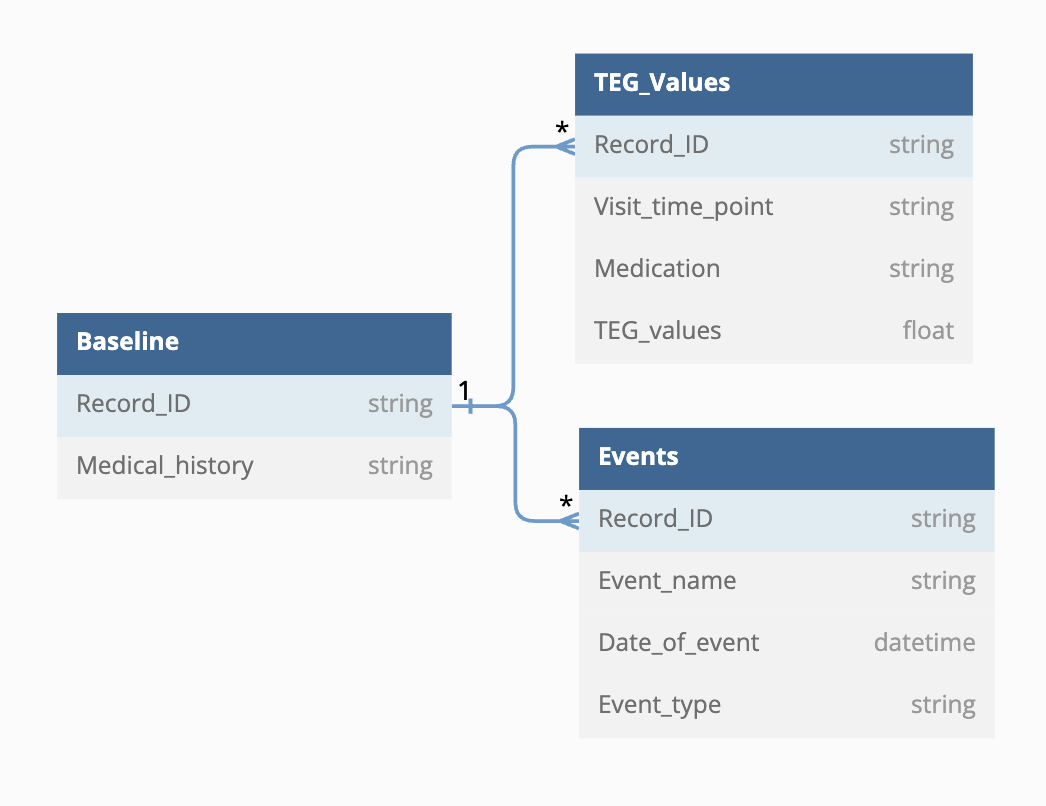

In [6]:
# Path to image
image_path = "./data/data_structure.png"
# Display the image
display(Image(filename=image_path, width=300, height=200))


In [7]:
# Copy data from baseline to teg values
merged_df = tegValues_df.merge(baseline_df, on='Record ID', how='outer')
merged_df

,Record ID,Visit Timepoint,Antiplatelet Therapy within 7 Days,Anticoagulation within 24 Hours,Statin within 24 Hours,Cilostazol within 7 days,Reaction Time (R) in min,Lysis at 30 min (LY30) in %,CRT Max amplitude (MA) in mm,CFF Max Amplitude( MA) in mm,...,Hx of pulmonary embolism,Does the patient have a history of solid organ transplant?,EGFR (mL/min/1.73m2),Has subject had previous intervention of the index limb?,Previous occluded stents,Rutherford Score,ABI Right,ABI left,Intervention Classification,Intervention Type
0,39,Baseline,"aspirin, ticagrelor",enoxaparin (Lovenox),Rosuvastatin,cilostazol,14.02407,1.268491,63.780276,37.48071,...,Yes,No,22.03354,Yes,0,4.717162,0.859011,0.104522,Open,angioplasty
1,39,Post Op Day 3( if applicable),"aspirin, ticagrelor","enoxaprin, warfarin",Rosuvastatin,NaN,8.89614,1.512165,*,42.19003,...,Yes,No,22.03354,Yes,0,4.717162,0.859011,0.104522,Open,angioplasty
2,39,PO Day 4,"clopidogrel, celecoxib","heparin, rivaroxaban",Pravastatin,cilostazol,6.505646,10.701757,62.400496,24.713521,...,Yes,No,22.03354,Yes,0,4.717162,0.859011,0.104522,Open,angioplasty
3,39,PO Day 1 ( 4-36 hours),"aspirin, ticagrelor",heparin (Calciparine),Lovastatin,cilostazol,9.980265,1.481315,74.171399,9.232926,...,Yes,No,22.03354,Yes,0,4.717162,0.859011,0.104522,Open,angioplasty
4,39,Readmission,ticagrelor,warfarin,Rosuvastatin,NaN,8.634896,7.256284,74.059581,13.195639,...,Yes,No,22.03354,Yes,0,4.717162,0.859011,0.104522,Open,angioplasty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,159,3 Month Post procedure,aspirin,warfarin,atorvastatin,NaN,9.738994,14.399443,57.183327,inconclusive,...,No,No,32.098739,No,0,not available,0.965327,1.264769,Open,"angioplasty, stent, endarterectomy"
796,159,Post op Day 2( if applicable),"clopidogrel, celecoxib","heparin, warfarin",Rosuvastatin,cilostazol,14.347525,2.403469,73.52181,10.643256,...,No,No,32.098739,No,0,not available,0.965327,1.264769,Open,"angioplasty, stent, endarterectomy"
797,159,30 Day Post Procedure,ticagrelor,"heparin, apixaban",Pravastatin,cilostazol,5.384667,8.739894,40.541836,42.128972,...,No,No,32.098739,No,0,not available,0.965327,1.264769,Open,"angioplasty, stent, endarterectomy"
798,159,PO Day 4,ticagrelor,heparin (Calciparine),Rosuvastatin,NaN,15.379638,11.985422,69.803245,20.039991,...,No,No,32.098739,No,0,not available,0.965327,1.264769,Open,"angioplasty, stent, endarterectomy"


In [8]:
# Count the number of events for each 'Record_ID' in events_df
event_counts = events_df['Record ID'].value_counts().reset_index()
event_counts.columns = ['Record ID', 'Events']
event_counts

,Record ID,Events
0,71,6
1,49,5
2,155,5
3,82,5
4,174,5
5,77,4
6,115,4
7,46,4
8,192,4
9,T21-41,4


In [9]:
# Merge the event counts with the merged_df
merged_df = merged_df.merge(event_counts, on='Record ID', how='left')
# Fill NaN values in the 'event_count' column with 0
merged_df['Events'].fillna(0, inplace=True)
merged_df

,Record ID,Visit Timepoint,Antiplatelet Therapy within 7 Days,Anticoagulation within 24 Hours,Statin within 24 Hours,Cilostazol within 7 days,Reaction Time (R) in min,Lysis at 30 min (LY30) in %,CRT Max amplitude (MA) in mm,CFF Max Amplitude( MA) in mm,...,Does the patient have a history of solid organ transplant?,EGFR (mL/min/1.73m2),Has subject had previous intervention of the index limb?,Previous occluded stents,Rutherford Score,ABI Right,ABI left,Intervention Classification,Intervention Type,Events
0,39,Baseline,"aspirin, ticagrelor",enoxaparin (Lovenox),Rosuvastatin,cilostazol,14.02407,1.268491,63.780276,37.48071,...,No,22.03354,Yes,0,4.717162,0.859011,0.104522,Open,angioplasty,3.0
1,39,Post Op Day 3( if applicable),"aspirin, ticagrelor","enoxaprin, warfarin",Rosuvastatin,NaN,8.89614,1.512165,*,42.19003,...,No,22.03354,Yes,0,4.717162,0.859011,0.104522,Open,angioplasty,3.0
2,39,PO Day 4,"clopidogrel, celecoxib","heparin, rivaroxaban",Pravastatin,cilostazol,6.505646,10.701757,62.400496,24.713521,...,No,22.03354,Yes,0,4.717162,0.859011,0.104522,Open,angioplasty,3.0
3,39,PO Day 1 ( 4-36 hours),"aspirin, ticagrelor",heparin (Calciparine),Lovastatin,cilostazol,9.980265,1.481315,74.171399,9.232926,...,No,22.03354,Yes,0,4.717162,0.859011,0.104522,Open,angioplasty,3.0
4,39,Readmission,ticagrelor,warfarin,Rosuvastatin,NaN,8.634896,7.256284,74.059581,13.195639,...,No,22.03354,Yes,0,4.717162,0.859011,0.104522,Open,angioplasty,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,159,3 Month Post procedure,aspirin,warfarin,atorvastatin,NaN,9.738994,14.399443,57.183327,inconclusive,...,No,32.098739,No,0,not available,0.965327,1.264769,Open,"angioplasty, stent, endarterectomy",2.0
796,159,Post op Day 2( if applicable),"clopidogrel, celecoxib","heparin, warfarin",Rosuvastatin,cilostazol,14.347525,2.403469,73.52181,10.643256,...,No,32.098739,No,0,not available,0.965327,1.264769,Open,"angioplasty, stent, endarterectomy",2.0
797,159,30 Day Post Procedure,ticagrelor,"heparin, apixaban",Pravastatin,cilostazol,5.384667,8.739894,40.541836,42.128972,...,No,32.098739,No,0,not available,0.965327,1.264769,Open,"angioplasty, stent, endarterectomy",2.0
798,159,PO Day 4,ticagrelor,heparin (Calciparine),Rosuvastatin,NaN,15.379638,11.985422,69.803245,20.039991,...,No,32.098739,No,0,not available,0.965327,1.264769,Open,"angioplasty, stent, endarterectomy",2.0


In [10]:
# Save in excel
merged_df.to_excel("./data/merged_data.xlsx", index=False)

### Data transformations
All columns are being transformed to the best fitting format, according to the information they hold and effectively removing any typos.

In [11]:
# Clean df in new copy
clean_df = merged_df.copy()

#### Number
- Age
- BMI
- Clotting Disorder
- EGFR (mL/min/1.73m2)
- BP prior to blood draw
- TEG values
- Visit Timepoint
- ABI Right
- ABI Left
- Rutherford Score

In [12]:
# Find teg values column
columns_to_exclude = ['Record ID', 'Visit Timepoint', 'Antiplatelet Therapy within 7 Days',
                      'Anticoagulation within 24 Hours', 'Statin within 24 Hours', 'Cilostazol within 7 days',
                      'BP prior to blood draw']

tegValues = [col for col in tegValues_df.columns.values if col not in columns_to_exclude]
tegValues

['Reaction Time (R) in min',
 'Lysis at 30 min (LY30) in %',
 'CRT Max amplitude (MA) in mm',
 'CFF Max Amplitude( MA) in mm',
 'HKH MA (mm)',
 'ActF MA (mm)',
 'ADP MA (mm)',
 'AA MA(mm)',
 'ADP % Aggregation',
 'ADP % Inhibition',
 'AA % Aggregation',
 'AA % Inhibition',
 'CK R(min)',
 'CK K (min)',
 'CK angle( deg)',
 'CK MA (mm)',
 'CRT MA(mm)',
 'CKH R (min)',
 'CFF MA(mm)',
 'CFF FLEV(mg/dL)',
 'HbA1c Baseline( within1 year of study start)',
 'INR value',
 'aPTT',
 'PT value',
 'WBC in K/uL',
 'RBC (M/uL)',
 'HGB(g/dL)',
 'HCT %',
 'PLT(K/uL)']

In [13]:
# Visualize the values and their types to identify the kind of changes needed
clean_df[["Visit Timepoint","Age","BMI", "Clotting Disorder", "EGFR (mL/min/1.73m2)", "BP prior to blood draw", "ABI Right", "ABI left", "Rutherford Score"]+tegValues].dtypes

Visit Timepoint                                  object
Age                                               int64
BMI                                             float64
Clotting Disorder                                 int64
EGFR (mL/min/1.73m2)                             object
BP prior to blood draw                           object
ABI Right                                        object
ABI left                                         object
Rutherford Score                                 object
Reaction Time (R) in min                         object
Lysis at 30 min (LY30) in %                      object
CRT Max amplitude (MA) in mm                     object
CFF Max Amplitude( MA) in mm                     object
HKH MA (mm)                                      object
ActF MA (mm)                                     object
ADP MA (mm)                                      object
AA MA(mm)                                        object
ADP % Aggregation                               

In [14]:
# Visualize the values 
clean_df[["Visit Timepoint","Age","BMI", "Clotting Disorder", "EGFR (mL/min/1.73m2)", "BP prior to blood draw", "ABI Right", "ABI left", "Rutherford Score"]+tegValues].head()

,Visit Timepoint,Age,BMI,Clotting Disorder,EGFR (mL/min/1.73m2),BP prior to blood draw,ABI Right,ABI left,Rutherford Score,Reaction Time (R) in min,...,CFF FLEV(mg/dL),HbA1c Baseline( within1 year of study start),INR value,aPTT,PT value,WBC in K/uL,RBC (M/uL),HGB(g/dL),HCT %,PLT(K/uL)
0,Baseline,81,40.373643,2,22.03354,160/95,0.859011,0.104522,4.717162,14.02407,...,1150.210716,5.764743,151.757216,121.451182,6.723782,12.394838,4.334694,10.318403,47.959012,155.287685
1,Post Op Day 3( if applicable),81,40.373643,2,22.03354,211/77,0.859011,0.104522,4.717162,8.89614,...,1836.823615,6.912360,47.695075,25.543697,10.633633,7.589757,6.373598,10.939432,24.180628,523.551954
2,PO Day 4,81,40.373643,2,22.03354,163/179,0.859011,0.104522,4.717162,6.505646,...,1016.377421,9.239307,95.632378,>150.0,7.196282,4.737160,2.926077,11.262388,34.631247,495.190573
3,PO Day 1 ( 4-36 hours),81,40.373643,2,22.03354,128/42,0.859011,0.104522,4.717162,9.980265,...,860.999044,9.981147,92.344739,71.631907,10.104878,21.827170,5.455922,9.935728,50.881666,601.947436
4,Readmission,81,40.373643,2,22.03354,81/177,0.859011,0.104522,4.717162,8.634896,...,1275.437489,7.835895,68.334368,114.900963,14.967546,17.637641,4.096517,8.177299,31.550726,192.943757


Out of the columns visuzlied, age, BMI and clotting dissorder are in the right format.

BP needs to be split between systolic and diastolic and made into ints.

EGFR is a combination of strings and floats. The string is ">60", which can be approximated to a big number, like 65. All the other values are floats.
TEG values need to be transformed to floats. Some teg values have maximum value stored as ">n", or say "inconclusive" or other string when data was not colected. Those vaues wil be marked as nan
Both TEG values and EGFR boundary conditions are saved in the "./data_boundary.json" file

Visit timepoint is in strings and need to be based on days

ABI left and right have some strings that will be converted to NaN values

Split BP into two columns (systolic and diastolic) based on "/" 

In [15]:
# Split the column into 'Systolic' and 'Diastolic' columns
clean_df[['BP_Systolic', 'BP_Diastolic']] = clean_df['BP prior to blood draw'].str.split('/', expand=True)

# Convert 'Systolic' and 'Diastolic' columns to integers
clean_df['BP_Systolic'] = pd.to_numeric(clean_df['BP_Systolic'], errors='coerce').astype('Int64')
clean_df['BP_Diastolic'] = pd.to_numeric(clean_df['BP_Diastolic'], errors='coerce').astype('Int64')

# Drop the first column 'BP prior to blood draw'
clean_df.drop(columns=['BP prior to blood draw'], inplace = True)

clean_df[['BP_Systolic', 'BP_Diastolic']].dtypes


BP_Systolic     Int64
BP_Diastolic    Int64
dtype: object

Clean EGFR and TEG data with boundary values and convert all to floats

In [16]:
# Import boundary values

# Get the current working directory (base directory)
base_directory = os.getcwd()

# Define the filename
filename = 'data_boundaries.json'

# Create the full file path by joining the base directory and filename
file_path = os.path.join(base_directory, 'data', filename)

with open(file_path, 'r') as json_file:
    boundaries = json.load(json_file)
boundaries

{'EGFR (mL/min/1.73m2)': {'>60': 50},
 'Reaction Time (R) in min': {'>17': 18},
 'CRT Max amplitude (MA) in mm': {'<40': 45, '>75': 80},
 'CFF Max Amplitude( MA) in mm': {'>52': 55, '<4': 3},
 'HKH MA (mm)': {'<42': 40, '>71': 75},
 'ActF MA (mm)': {'>30': 35, '<2': 0},
 'ADP MA (mm)': {'<10': 5, '>72': 77},
 'AA MA(mm)': {'<8': 5},
 'CK R(min)': {'>17': 20},
 'CK K (min)': {'<': '>', '>5': 8},
 'CK angle( deg)': {'<39': 35},
 'CK MA (mm)': {'<40': 35, '>75': 80},
 'CRT MA(mm)': {'<40': 35, '>75': 80},
 'CKH R (min)': {'>17': 20},
 'CFF MA(mm)': {'>52': 55, '<4': 0},
 'aPTT': {'>150': 160}}

In [17]:
# Replace all boundary values with their correcponding right values

# Iterate over the DataFrame and apply boundaries
for column, replacement_dict in boundaries.items():
    
    # Remove spaces in the column
    clean_df[column] = clean_df[column].replace(regex={r'\s': ''})
    
    # Use a regular expression to match and replace values
    for name, replacement in replacement_dict.items():
        clean_df[column] = clean_df[column].replace({f'^{name}': replacement}, regex=True)

# Show changes    
clean_df[list(boundaries.keys())].head()

,EGFR (mL/min/1.73m2),Reaction Time (R) in min,CRT Max amplitude (MA) in mm,CFF Max Amplitude( MA) in mm,HKH MA (mm),ActF MA (mm),ADP MA (mm),AA MA(mm),CK R(min),CK K (min),CK angle( deg),CK MA (mm),CRT MA(mm),CKH R (min),CFF MA(mm),aPTT
0,22.03354,14.02407,63.780276,37.48071,60.551078,4.005524,33.115271,66.890611,530.964454,2.74555,35,35,65.81586,31.275554,8.07024,121.451182
1,22.03354,8.89614,*,42.19003,5.845266,13.80792,5,73.48474,432.723049,3.816433,40.044549,53.708025,84.098358,14.739294,31.715381,25.543697
2,22.03354,6.505646,62.400496,24.713521,5.413723,5.281582,14.793293,79.6129,397.174602,1.456415,58.096879,65.246337,85.698255,27.113082,34.523329,160
3,22.03354,9.980265,74.171399,9.232926,60.641538,28.36365,67.139059,10.605475,487.505,12.632675,63.53591,notavailable,47.218162,42.621104,14.189577,71.631907
4,22.03354,8.634896,74.059581,13.195639,31.972532,21.758607,25.251324,77.190775,429.718354,6.103538,75.576784,33.650237,61.410956,43.240154,36.570139,114.900963


In [18]:
# Convert EGFR, Rutherford Score and TEG values to float
columns_to_convert = tegValues +["EGFR (mL/min/1.73m2)", "Rutherford Score"]

# Loop through the columns and convert to numeric
for column in columns_to_convert:
    clean_df[column] = pd.to_numeric(clean_df[column], errors='coerce')

clean_df[columns_to_convert].dtypes

Reaction Time (R) in min                        float64
Lysis at 30 min (LY30) in %                     float64
CRT Max amplitude (MA) in mm                    float64
CFF Max Amplitude( MA) in mm                    float64
HKH MA (mm)                                     float64
ActF MA (mm)                                    float64
ADP MA (mm)                                     float64
AA MA(mm)                                       float64
ADP % Aggregation                               float64
ADP % Inhibition                                float64
AA % Aggregation                                float64
AA % Inhibition                                 float64
CK R(min)                                       float64
CK K (min)                                      float64
CK angle( deg)                                  float64
CK MA (mm)                                      float64
CRT MA(mm)                                      float64
CKH R (min)                                     

In [19]:
# Show values to make sure strings were changed to NaN
clean_df[list(boundaries.keys())].head()

,EGFR (mL/min/1.73m2),Reaction Time (R) in min,CRT Max amplitude (MA) in mm,CFF Max Amplitude( MA) in mm,HKH MA (mm),ActF MA (mm),ADP MA (mm),AA MA(mm),CK R(min),CK K (min),CK angle( deg),CK MA (mm),CRT MA(mm),CKH R (min),CFF MA(mm),aPTT
0,22.03354,14.024070,63.780276,37.480710,60.551078,4.005524,33.115271,66.890611,530.964454,2.745550,35.000000,35.000000,65.815860,31.275554,8.070240,121.451182
1,22.03354,8.896140,NaN,42.190030,5.845266,13.807920,5.000000,73.484740,432.723049,3.816433,40.044549,53.708025,84.098358,14.739294,31.715381,25.543697
2,22.03354,6.505646,62.400496,24.713521,5.413723,5.281582,14.793293,79.612900,397.174602,1.456415,58.096879,65.246337,85.698255,27.113082,34.523329,160.000000
3,22.03354,9.980265,74.171399,9.232926,60.641538,28.363650,67.139059,10.605475,487.505000,12.632675,63.535910,NaN,47.218162,42.621104,14.189577,71.631907
4,22.03354,8.634896,74.059581,13.195639,31.972532,21.758607,25.251324,77.190775,429.718354,6.103538,75.576784,33.650237,61.410956,43.240154,36.570139,114.900963


Change timepoints from strings to ints that represent days after the operation.

All the values are saved in ./data/timepoints.json

In [20]:
# Define the filename
filename = 'timepoints.json'

# Create the full file path by joining the base directory and filename
file_path = os.path.join(base_directory, 'data', filename)


with open(file_path, 'r') as json_file:
    timepoints = json.load(json_file)
timepoints

{'0': ['Baseline', 'Enrollment + Baseline'],
 '1': ['6hr Post', 'PO Day 1 ( 4-36 hours)', 'Post Op day 1 (4-36 hours)'],
 '2': ['PO Day 2', 'Post op Day 2( if applicable)'],
 '3': ['PO Day 3', 'Post Op Day 3( if applicable)'],
 '4': ['PO Day 4', 'Post Op Day 4 ( if applicable)'],
 '5': ['PO day 5', 'Post Op Day 5 ( if applicable)'],
 '30': ['1M PO', '30 Day Post Procedure'],
 '90': ['3M PO', '3 Month Post procedure'],
 '180': ['6M PO', '6 month Post Procedure', 'Readmission']}

In [21]:
# Create a reverse mapping dictionary
reverse_mapping = {v: k for k, values in timepoints.items() for v in values}

# Replace values using the reverse mapping
clean_df['Days from operation'] = clean_df['Visit Timepoint'].map(reverse_mapping)

# Convert the column to integer
clean_df['Days from operation'] = clean_df['Days from operation'].astype(int)

# Drop old column
clean_df.drop(columns=['Visit Timepoint'], inplace = True)


In [22]:
clean_df['Days from operation'].dtype

dtype('int64')

Convert ABI values to floats

In [23]:
clean_df['ABI Right'] = pd.to_numeric(clean_df['ABI Right'], errors='coerce')
clean_df['ABI left'] = pd.to_numeric(clean_df['ABI left'], errors='coerce')

clean_df[['ABI Right', 'ABI left']].dtypes

ABI Right    float64
ABI left     float64
dtype: object

In [24]:
# Appreciate all your work
clean_df[["Days from operation","Age","BMI", "Clotting Disorder", "EGFR (mL/min/1.73m2)", "BP_Systolic", "BP_Diastolic", 'ABI Right', 'ABI left']+tegValues].head()

,Days from operation,Age,BMI,Clotting Disorder,EGFR (mL/min/1.73m2),BP_Systolic,BP_Diastolic,ABI Right,ABI left,Reaction Time (R) in min,...,CFF FLEV(mg/dL),HbA1c Baseline( within1 year of study start),INR value,aPTT,PT value,WBC in K/uL,RBC (M/uL),HGB(g/dL),HCT %,PLT(K/uL)
0,0,81,40.373643,2,22.03354,160,95,0.859011,0.104522,14.024070,...,1150.210716,5.764743,151.757216,121.451182,6.723782,12.394838,4.334694,10.318403,47.959012,155.287685
1,3,81,40.373643,2,22.03354,211,77,0.859011,0.104522,8.896140,...,1836.823615,6.912360,47.695075,25.543697,10.633633,7.589757,6.373598,10.939432,24.180628,523.551954
2,4,81,40.373643,2,22.03354,163,179,0.859011,0.104522,6.505646,...,1016.377421,9.239307,95.632378,160.000000,7.196282,4.737160,2.926077,11.262388,34.631247,495.190573
3,1,81,40.373643,2,22.03354,128,42,0.859011,0.104522,9.980265,...,860.999044,9.981147,92.344739,71.631907,10.104878,21.827170,5.455922,9.935728,50.881666,601.947436
4,180,81,40.373643,2,22.03354,81,177,0.859011,0.104522,8.634896,...,1275.437489,7.835895,68.334368,114.900963,14.967546,17.637641,4.096517,8.177299,31.550726,192.943757


#### Booleans
- Sex
- White
- Diabetes
- Hypertension
- Hyperlipidemia
- Coronary Artery Disease
- History of MI 
- Functional impairment
- Does Subject Currently have cancer?
- Past hx of cancer
- Hx of  DVT
- Hx of stroke
- Hx of pulmonary embolism:
- Does the patient have a history of solid organ transplant?
- Has subject had previous intervention of the index limb? 
- Previous occluded stents
- Cilostazol within 7 days

In [25]:
# Create the 'Is Male' column based on the 'sex' column
clean_df['Is Male'] = (clean_df['Sex'] == 'Male').astype(bool)

# Drop the old 'sex' column
clean_df.drop('Sex', axis=1, inplace=True)
clean_df['Is Male']

0       True
1       True
2       True
3       True
4       True
       ...  
795    False
796    False
797    False
798    False
799    False
Name: Is Male, Length: 800, dtype: bool

In [26]:
# Change following columns to booleans
columns_to_convert = ['White', 'Diabetes', 'Hypertension', 'Hyperlipidemia (choice=None)', 'Coronary Artery Disease', 'History of MI',
                      'Functional impairment', 'Does Subject Currently have cancer?', 'Past hx of cancer', 'Hx of  DVT', 'Hx of stroke',
                      'Hx of pulmonary embolism', 'Does the patient have a history of solid organ transplant?', 
                      'Has subject had previous intervention of the index limb?', 'Previous occluded stents','Cilostazol within 7 days']
clean_df[columns_to_convert]

,White,Diabetes,Hypertension,Hyperlipidemia (choice=None),Coronary Artery Disease,History of MI,Functional impairment,Does Subject Currently have cancer?,Past hx of cancer,Hx of DVT,Hx of stroke,Hx of pulmonary embolism,Does the patient have a history of solid organ transplant?,Has subject had previous intervention of the index limb?,Previous occluded stents,Cilostazol within 7 days
0,1,1,0,1,No,Yes,0,No,No,Yes,No,Yes,No,Yes,0,cilostazol
1,1,1,0,1,No,Yes,0,No,No,Yes,No,Yes,No,Yes,0,NaN
2,1,1,0,1,No,Yes,0,No,No,Yes,No,Yes,No,Yes,0,cilostazol
3,1,1,0,1,No,Yes,0,No,No,Yes,No,Yes,No,Yes,0,cilostazol
4,1,1,0,1,No,Yes,0,No,No,Yes,No,Yes,No,Yes,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1,0,0,0,No,No,1,Yes,No,Yes,Yes,No,No,No,0,NaN
796,1,0,0,0,No,No,1,Yes,No,Yes,Yes,No,No,No,0,cilostazol
797,1,0,0,0,No,No,1,Yes,No,Yes,Yes,No,No,No,0,cilostazol
798,1,0,0,0,No,No,1,Yes,No,Yes,Yes,No,No,No,0,NaN


In [27]:
# Dictionary for replacement
replacement_dict = {'yes': True, 'no': False, '1': True, '0': False, 'cilostazol': True, 'NaN':False}

In [28]:
# Fill NaN values with False
clean_df[columns_to_convert] = clean_df[columns_to_convert].fillna('0')

# Put all columns in lowercase
clean_df[columns_to_convert] = clean_df[columns_to_convert].astype(str)
clean_df[columns_to_convert] = clean_df[columns_to_convert].apply(lambda x: x.str.lower())

# Use the replace method to replace values in multiple columns
clean_df[columns_to_convert] = clean_df[columns_to_convert].replace(replacement_dict).astype(bool)

clean_df[columns_to_convert]


,White,Diabetes,Hypertension,Hyperlipidemia (choice=None),Coronary Artery Disease,History of MI,Functional impairment,Does Subject Currently have cancer?,Past hx of cancer,Hx of DVT,Hx of stroke,Hx of pulmonary embolism,Does the patient have a history of solid organ transplant?,Has subject had previous intervention of the index limb?,Previous occluded stents,Cilostazol within 7 days
0,True,True,False,True,False,True,False,False,False,True,False,True,False,True,False,True
1,True,True,False,True,False,True,False,False,False,True,False,True,False,True,False,False
2,True,True,False,True,False,True,False,False,False,True,False,True,False,True,False,True
3,True,True,False,True,False,True,False,False,False,True,False,True,False,True,False,True
4,True,True,False,True,False,True,False,False,False,True,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,True,False,False,False,False,False,True,True,False,True,True,False,False,False,False,False
796,True,False,False,False,False,False,True,True,False,True,True,False,False,False,False,True
797,True,False,False,False,False,False,True,True,False,True,True,False,False,False,False,True
798,True,False,False,False,False,False,True,True,False,True,True,False,False,False,False,False


#### Categorical ordinal
- Tobacco Use
- Renal Status

In [29]:
# Ordinal encoding map
category_orders = {
    'Tobacco Use (1 current 2 former, 3 none)': 
    ['None',
    'Past, quit >10 year ago',
    'quit 1 to 10 years ago', 
    'current within the last year ( < 1 pack a day)',
    'current within the last year (  > or = 1 pack a day)'],

    'Renal Status': 
    ['Normal', 
    'GFR 30 to 59', 
    'GFR 15 to 29', 
    'GFR<15 or patient is on dialysis',
    '1']
}

In [30]:
# Replace renal status values. Some of the values in the data set mean the same with different words
# Define a dictionary to map old values to new values
replace_dict = {'GFR 60 to 89': 'Normal', 'Evidence of renal dysfunction ( GFR >90)': 'Normal', '0': 'Normal', 0: 'Normal', 1: "1"}

clean_df['Renal Status'] = clean_df['Renal Status'].replace(replace_dict)

# Initialize the OrdinalEncoder with specified category orders
encoder = OrdinalEncoder(categories=[category_orders[column] for column in ['Tobacco Use (1 current 2 former, 3 none)', 'Renal Status']])

# Fit and transform the selected columns to encode ordinal values
clean_df[['Tobacco Use (1 current 2 former, 3 none)', 'Renal Status']] = encoder.fit_transform(clean_df[['Tobacco Use (1 current 2 former, 3 none)', 'Renal Status']])

# Rename column
clean_df = clean_df.rename(columns={'Tobacco Use (1 current 2 former, 3 none)': 'Tobacco Use'})

In [31]:
clean_df[['Tobacco Use', 'Renal Status']]

,Tobacco Use,Renal Status
0,3.0,0.0
1,3.0,0.0
2,3.0,0.0
3,3.0,0.0
4,3.0,0.0
...,...,...
795,4.0,0.0
796,4.0,0.0
797,4.0,0.0
798,4.0,0.0


#### Categorical nominal
- Extremity
- Artery affected
- Intervention Classification
- Intervention Type
- Antiplatelet Therapy within 7 Days
- Anticoagulation within 24 Hours
- Statin within 24 Hours


In [32]:
columns_to_dummy = ['Extremity',
                    'Intervention Classification',
                    'Statin within 24 Hours']

In [33]:
# Dummy encoding of categorical values
clean_df = pd.get_dummies(clean_df, columns=columns_to_dummy,
                    prefix=columns_to_dummy)

In [34]:
# Drop unecessary columns
clean_df = clean_df.drop(columns=['Extremity_left']) # Because it is either right, left or bilateral
clean_df = clean_df.drop(columns=['Intervention Classification_Endo']) # Either endo, open or combined

In [35]:
# Show columns 
# Use the .filter() method to select columns with the original columns prefixes
dummy_columns = selected_columns = [col for col in clean_df.columns if any(col.startswith(prefix) for prefix in columns_to_dummy)]

clean_df[dummy_columns]

,Extremity_Bilateral,Extremity_right,Intervention Classification_Combined,Intervention Classification_Open,Statin within 24 Hours_Lovastatin,Statin within 24 Hours_Pravastatin,Statin within 24 Hours_Rosuvastatin,Statin within 24 Hours_Simvastatin,Statin within 24 Hours_atorvastatin
0,False,False,False,True,False,False,True,False,False
1,False,False,False,True,False,False,True,False,False
2,False,False,False,True,False,True,False,False,False
3,False,False,False,True,True,False,False,False,False
4,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...
795,True,False,False,True,False,False,False,False,True
796,True,False,False,True,False,False,True,False,False
797,True,False,False,True,False,True,False,False,False
798,True,False,False,True,False,False,True,False,False


The _Artery affected_, _Intervention type_, _Antiplatelet Therapy within 7 Days_, and _Anticoagulation within 24 Hours_ column has multiple values in a sigle string. They will be normalized before being encoded

Artery affected

In [36]:
# Get all unique valuses
unique_arteries = set()
unique_antiplatelet = set()
unique_intervention = set()
unique_anticoagulation = set()

for index, row in clean_df.iterrows():
    arteries = row['Artery affected'].split(', ')
    unique_arteries.update(arteries)

    antiplatelet = row['Antiplatelet Therapy within 7 Days'].split(', ')
    unique_antiplatelet.update(antiplatelet)

    intervention = row['Intervention Type'].split(', ')
    unique_intervention.update(intervention)

    anticoagulation = row['Anticoagulation within 24 Hours'].split(', ')
    # Delete items in parenthesis ex: heparin (Calciparine) to be just heparin
    anticoagulation = {re.sub(r'\s*\([^)]*\)\s*', '', item) for item in anticoagulation} 
    unique_anticoagulation.update(anticoagulation)


print(unique_arteries)
print(unique_antiplatelet)
print(unique_intervention)
print(unique_anticoagulation)

{'SFA', 'external iliac', 'common femoral', 'popliteal', 'posterior tibial', 'internal iliac', 'anterior tibial', 'aortoiliac'}
{'ticagrelor', 'celecoxib', 'aspirin', 'clopidogrel'}
{'DVA', 'thrombectomy', 'angioplasty', 'stent', 'bypass revision', 'bypass', 'endarterectomy'}
{'apixaban', 'heparin', 'enoxaparin', 'enoxaprin', 'warfarin', 'rivaroxaban'}


In [37]:
# Dummy encode ateries affected
selected_arteries = []
for artery in unique_arteries:
    column_name = "Artery affected_"+artery
    clean_df[column_name] = clean_df['Artery affected'].str.contains(artery).astype(int)
    selected_arteries.append(column_name)

selected_arteries.append('Artery affected')
clean_df[selected_arteries]

,Artery affected_SFA,Artery affected_external iliac,Artery affected_common femoral,Artery affected_popliteal,Artery affected_posterior tibial,Artery affected_internal iliac,Artery affected_anterior tibial,Artery affected_aortoiliac,Artery affected
0,1,0,1,1,1,0,1,1,"common femoral, SFA, popliteal, anterior tibia..."
1,1,0,1,1,1,0,1,1,"common femoral, SFA, popliteal, anterior tibia..."
2,1,0,1,1,1,0,1,1,"common femoral, SFA, popliteal, anterior tibia..."
3,1,0,1,1,1,0,1,1,"common femoral, SFA, popliteal, anterior tibia..."
4,1,0,1,1,1,0,1,1,"common femoral, SFA, popliteal, anterior tibia..."
...,...,...,...,...,...,...,...,...,...
795,0,0,0,0,0,0,0,1,aortoiliac
796,0,0,0,0,0,0,0,1,aortoiliac
797,0,0,0,0,0,0,0,1,aortoiliac
798,0,0,0,0,0,0,0,1,aortoiliac


In [38]:
# Dummy encode antiplatelete therapy
selected_antiplatelet = []
for antiplatelet in unique_antiplatelet:
    column_name = "Antiplatelet therapy_"+antiplatelet
    clean_df[column_name] = clean_df['Antiplatelet Therapy within 7 Days'].str.contains(antiplatelet).astype(int)
    selected_antiplatelet.append(column_name)

selected_antiplatelet.append('Antiplatelet Therapy within 7 Days')
clean_df[selected_antiplatelet]

,Antiplatelet therapy_ticagrelor,Antiplatelet therapy_celecoxib,Antiplatelet therapy_aspirin,Antiplatelet therapy_clopidogrel,Antiplatelet Therapy within 7 Days
0,1,0,1,0,"aspirin, ticagrelor"
1,1,0,1,0,"aspirin, ticagrelor"
2,0,1,0,1,"clopidogrel, celecoxib"
3,1,0,1,0,"aspirin, ticagrelor"
4,1,0,0,0,ticagrelor
...,...,...,...,...,...
795,0,0,1,0,aspirin
796,0,1,0,1,"clopidogrel, celecoxib"
797,1,0,0,0,ticagrelor
798,1,0,0,0,ticagrelor


In [39]:
# Dummy encode intervention types
selected_intervention = []
for intervention in unique_intervention:
    column_name = 'Intervention type_'+intervention
    clean_df[column_name] = clean_df['Intervention Type'].str.contains(intervention).astype(int)
    selected_intervention.append(column_name)

selected_intervention.append('Intervention Type')
clean_df[selected_intervention]

,Intervention type_DVA,Intervention type_thrombectomy,Intervention type_angioplasty,Intervention type_stent,Intervention type_bypass revision,Intervention type_bypass,Intervention type_endarterectomy,Intervention Type
0,0,0,1,0,0,0,0,angioplasty
1,0,0,1,0,0,0,0,angioplasty
2,0,0,1,0,0,0,0,angioplasty
3,0,0,1,0,0,0,0,angioplasty
4,0,0,1,0,0,0,0,angioplasty
...,...,...,...,...,...,...,...,...
795,0,0,1,1,0,0,1,"angioplasty, stent, endarterectomy"
796,0,0,1,1,0,0,1,"angioplasty, stent, endarterectomy"
797,0,0,1,1,0,0,1,"angioplasty, stent, endarterectomy"
798,0,0,1,1,0,0,1,"angioplasty, stent, endarterectomy"


In [40]:
# Dummy encode anticoagulation meds
selected_anticoagulation = []
for anticoagulation in unique_anticoagulation:
    column_name = "Anticoagulation_"+anticoagulation
    clean_df[column_name] = clean_df['Anticoagulation within 24 Hours'].str.contains(anticoagulation).astype(int)
    selected_anticoagulation.append(column_name)

selected_anticoagulation.append('Anticoagulation within 24 Hours')
clean_df[selected_anticoagulation]

,Anticoagulation_apixaban,Anticoagulation_heparin,Anticoagulation_enoxaparin,Anticoagulation_enoxaprin,Anticoagulation_warfarin,Anticoagulation_rivaroxaban,Anticoagulation within 24 Hours
0,0,0,1,0,0,0,enoxaparin (Lovenox)
1,0,0,0,1,1,0,"enoxaprin, warfarin"
2,0,1,0,0,0,1,"heparin, rivaroxaban"
3,0,1,0,0,0,0,heparin (Calciparine)
4,0,0,0,0,1,0,warfarin
...,...,...,...,...,...,...,...
795,0,0,0,0,1,0,warfarin
796,0,1,0,0,1,0,"heparin, warfarin"
797,1,1,0,0,0,0,"heparin, apixaban"
798,0,1,0,0,0,0,heparin (Calciparine)


In [41]:
# Drop old columns
columns_to_drop = ['Artery affected', 'Antiplatelet Therapy within 7 Days','Intervention Type', 'Anticoagulation within 24 Hours']
clean_df.drop(columns=columns_to_drop, inplace=True)

In [42]:
# Save in excel
clean_df.to_excel("./data/clean_data.xlsx", index=False)

## Extend data
Create the rate of change of teg values colum

In [43]:
# Columns
tegValues

['Reaction Time (R) in min',
 'Lysis at 30 min (LY30) in %',
 'CRT Max amplitude (MA) in mm',
 'CFF Max Amplitude( MA) in mm',
 'HKH MA (mm)',
 'ActF MA (mm)',
 'ADP MA (mm)',
 'AA MA(mm)',
 'ADP % Aggregation',
 'ADP % Inhibition',
 'AA % Aggregation',
 'AA % Inhibition',
 'CK R(min)',
 'CK K (min)',
 'CK angle( deg)',
 'CK MA (mm)',
 'CRT MA(mm)',
 'CKH R (min)',
 'CFF MA(mm)',
 'CFF FLEV(mg/dL)',
 'HbA1c Baseline( within1 year of study start)',
 'INR value',
 'aPTT',
 'PT value',
 'WBC in K/uL',
 'RBC (M/uL)',
 'HGB(g/dL)',
 'HCT %',
 'PLT(K/uL)']

In [44]:
extended_df = clean_df.copy()

In [45]:
# Sort the DataFrame by "Record ID" and "Visit Timepoint"
extended_df= extended_df.sort_values(by=["Record ID", "Days from operation"])
extended_df[["Record ID", "Days from operation"]]

,Record ID,Days from operation
382,5,0
380,5,1
384,5,1
386,5,1
389,5,3
...,...,...
173,T21-63,5
163,T21-63,30
164,T21-63,30
166,T21-63,90


In [46]:
# Group by 'Record ID'
grouped = extended_df.groupby('Record ID')

#Calculate the difference in 'Days from operation'
extended_df['Days Diff'] = grouped['Days from operation'].diff()

# Replace 0s to avoid infinity
extended_df["Days Diff"] = extended_df["Days Diff"].replace(0, 1)

extended_df[["Record ID", "Days from operation", "Days Diff"]]


,Record ID,Days from operation,Days Diff
382,5,0,NaN
380,5,1,1.0
384,5,1,1.0
386,5,1,1.0
389,5,3,2.0
...,...,...,...
173,T21-63,5,1.0
163,T21-63,30,25.0
164,T21-63,30,1.0
166,T21-63,90,60.0


In [47]:
new_columns = []
# Iterate TEG values
for value in tegValues:

    # Get column names
    diff_column_name = f"{value}_difference_since_last_timepoint"
    rate_column_name = f"{value}_rate_since_last_timepoint"
    new_columns.append(diff_column_name)
    new_columns.append(rate_column_name)


    # Calculate the difference in TEG values
    extended_df[diff_column_name] = grouped[value].diff()

    # Divide  by the differences in 'Days from operation'
    extended_df[rate_column_name] = extended_df[diff_column_name] / extended_df['Days Diff']

# Fill the first value with the next one to avoid NaN
extended_df.bfill(inplace=True)

In [48]:
extended_df[new_columns]


,Reaction Time (R) in min_difference_since_last_timepoint,Reaction Time (R) in min_rate_since_last_timepoint,Lysis at 30 min (LY30) in %_difference_since_last_timepoint,Lysis at 30 min (LY30) in %_rate_since_last_timepoint,CRT Max amplitude (MA) in mm_difference_since_last_timepoint,CRT Max amplitude (MA) in mm_rate_since_last_timepoint,CFF Max Amplitude( MA) in mm_difference_since_last_timepoint,CFF Max Amplitude( MA) in mm_rate_since_last_timepoint,HKH MA (mm)_difference_since_last_timepoint,HKH MA (mm)_rate_since_last_timepoint,...,WBC in K/uL_difference_since_last_timepoint,WBC in K/uL_rate_since_last_timepoint,RBC (M/uL)_difference_since_last_timepoint,RBC (M/uL)_rate_since_last_timepoint,HGB(g/dL)_difference_since_last_timepoint,HGB(g/dL)_rate_since_last_timepoint,HCT %_difference_since_last_timepoint,HCT %_rate_since_last_timepoint,PLT(K/uL)_difference_since_last_timepoint,PLT(K/uL)_rate_since_last_timepoint
382,12.718378,12.718378,4.652072,4.652072,0.925788,0.925788,-29.004394,-29.004394,56.059502,56.059502,...,0.954498,0.954498,0.073992,0.073992,-6.667564,-6.667564,12.655531,12.655531,381.144204,381.144204
380,12.718378,12.718378,4.652072,4.652072,0.925788,0.925788,-29.004394,-29.004394,56.059502,56.059502,...,0.954498,0.954498,0.073992,0.073992,-6.667564,-6.667564,12.655531,12.655531,381.144204,381.144204
384,-8.311065,-8.311065,11.731168,5.865584,9.747366,9.747366,15.544335,15.544335,-47.225873,-47.225873,...,-1.000413,-1.000413,-0.753583,-0.753583,8.473345,8.473345,-17.624743,-17.624743,-499.469330,-499.469330
386,10.773672,10.773672,11.731168,5.865584,-7.780970,-7.780970,2.728388,2.728388,-14.184491,-14.184491,...,-1.161365,-1.161365,-2.148798,-2.148798,-1.093748,-1.093748,-5.690214,-5.690214,471.861546,471.861546
389,-7.357549,-7.357549,11.731168,5.865584,19.661134,9.830567,-16.396297,-8.198148,-3.809000,-1.904500,...,4.082540,2.041270,0.657222,0.328611,-6.683472,-3.341736,-3.809204,-1.904602,-439.080783,-219.540391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,5.407998,5.407998,-15.987030,-15.987030,-31.208533,-1.248341,-10.096807,-10.096807,31.968000,31.968000,...,5.985353,5.985353,1.296360,1.296360,8.114565,8.114565,-0.836521,-0.836521,78.949279,78.949279
163,0.483487,0.019339,13.321286,0.532851,-31.208533,-1.248341,11.444630,0.457785,12.674935,0.506997,...,-4.042955,-0.161718,-0.595934,-0.023837,3.408579,0.136343,7.077759,0.283110,-175.505866,-7.020235
164,3.161806,0.035131,-8.006883,-8.006883,-8.695879,-8.695879,-42.451061,-42.451061,-32.866860,-32.866860,...,2.799659,2.799659,0.614396,0.614396,-4.681215,-4.681215,8.585907,8.585907,-160.590045,-160.590045
166,3.161806,0.035131,-3.265605,-0.054427,NaN,NaN,29.625695,0.493762,-15.500802,-0.258347,...,-15.012593,-0.250210,-3.251790,-0.054197,0.225771,0.003763,-28.885626,-0.481427,-85.342491,-1.422375


In [49]:
# Drop column with diff in dates
extended_df.drop(columns=["Days Diff"], inplace = True)

In [50]:
# Save in excel
extended_df.to_excel("./data/extended_data.xlsx", index=False)

## Data visualization
The goal of this section is to create the graphs that will be shown to the user describing the general data demographics

In [51]:
fig_df = clean_df.copy()

In [52]:
 # Define custom colors
male_colors = ['#d9ed92', '#99d98c'] 
white_colors = ['#184e77', '#1a759f'] 
events_colors = '#1a759f'
age_histogram_color = '#52b69a' 
bmi_histogram_color = '#1e6091'

In [53]:
# Count binary values in the "Male" column
male_counts = fig_df['Is Male'].value_counts()
male_labels = ['Male' if male_counts.index[0] else 'Female', 'Male' if not male_counts.index[0] else 'Female']
# Create a pie chart for "Male" with custom colors
sex_pie = go.Pie(labels=male_labels, values=male_counts, marker=dict(colors=male_colors))

# Visualize
data = [sex_pie]
fig = go.Figure(data = data)
fig.update_layout(width=300, height=300)
display(fig)

In [54]:
# Count binary values in the "White" column
white_counts = fig_df['White'].value_counts()
white_labels = ['White' if white_counts.index[0] else 'Non-White', 'White' if not white_counts.index[0] else 'Non-White']

# Create a pie chart for "White" with custom colors
white_pie = go.Pie(labels=white_labels, values=white_counts, marker=dict(colors=white_colors))

# Visualize
data = [white_pie]
fig = go.Figure(data = data)
fig.update_layout(width=300, height=300)
display(fig)

In [55]:
# Events histogram
events_hist =  go.Histogram(x=fig_df["Events"], name="Events", marker=dict(color=events_colors))

# Visualize
data = [events_hist]
fig = go.Figure(data = data)
fig.update_layout(width=300, height=300)
display(fig)

In [56]:
# BMI histogram
bmi_hist =  go.Histogram(x=fig_df["BMI"], name="BMI", marker=dict(color=bmi_histogram_color))

# Visualize
data = [bmi_hist]
fig = go.Figure(data = data)
fig.update_layout(width=300, height=300)
display(fig)

In [57]:
# Age histogram
age_hist=  go.Histogram(x=fig_df["Age"], name="Age", marker=dict(color=age_histogram_color))

# Visualize
data = [age_hist]
fig = go.Figure(data = data)
fig.update_layout(width=300, height=300)
display(fig)

In [58]:
# Create a summary table
unique_patients = fig_df['Record ID'].nunique()
total_data_points = len(fig_df)

data_summary = pd.DataFrame({
    'Category': ['Unique Patients', 'Total Data Points'],
    'Count': [unique_patients, total_data_points]
})

patients_table = go.Table(
    header=dict(values=["Category", "Count"]),
    cells=dict(values=[data_summary['Category'], data_summary['Count']])
)

# Visualize
data = [patients_table]
fig = go.Figure(data = data)
fig.update_layout(width=300, height=300)
display(fig)

In [59]:
# Create subplots
fig = make_subplots(rows=2, cols=3,
                    specs=[[{'type':'domain'}, {'type':'domain'},{'type':'xy'}],
                            [{'type':'xy'}, {'type':'xy'},{'type':'domain'}]],
                    subplot_titles=['Gender Distribution', 'Ethnicity Distribution', 'Thrombotic event', 'BMI',
                                    'Age', 'Data Summary'])

fig.add_trace(sex_pie, row=1, col=1)
fig.add_trace(white_pie, row=1, col=2)
fig.add_trace(events_hist, row=1, col=3)
fig.add_trace(bmi_hist, row=2, col=1)
fig.add_trace(age_hist, row=2, col=2)
fig.add_trace(patients_table, row=2, col=3)

fig.update_layout(width=900, height=600)
display(fig)

## Train model 1
This section shows steps needed to create a model. For the final version of this project two iterations of the model will be run.

In [60]:
model1_df = extended_df.copy()

In [61]:
# Separate features (X) and target (y)
y = model1_df['Events']
X = model1_df.drop(labels=['Events', 'Record ID'], axis=1)

In [62]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Create transformers for feature scaling
feature_scaler = RobustScaler()
target_scaler = MinMaxScaler()

In [64]:
# Create a pipeline
pipeline = Pipeline([
    ('feature_scaler', feature_scaler),  # Robust scaling for features
    ('target_scaler', target_scaler),    # Min-Max scaling for the target
    ('xgb_regressor', XGBRegressor())    # XGBoost regressor
])

In [65]:
# Define hyperparameter grid for tuning (adjust as needed)
param_dist = {
    # The maximum depth of each tree in the ensemble.
    'xgb_regressor__max_depth': [3, 4, 5],
    # Minimum loss reduction required to make a further partition on a leaf node.
    'xgb_regressor__gamma': [0, 0.1, 0.2],
    # Minimum sum of instance weight (hessian) needed in a child.
    'xgb_regressor__min_child_weight': [1, 2, 5]
}

In [66]:
# Initialize K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [67]:
# Initialize GridSearchCV for hyperparameter tuning
# CONFIRM WITH CDR. 
# -   Might not ue accuracy to score.
# -   Choose n_iter 
randomized_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist,
                                        n_iter=25, scoring='r2', cv=kf, random_state=42)


In [68]:
# Fit the model and perform hyperparameter tuning
randomized_search.fit(X_train, y_train)

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning:

is_sparse is deprecated and will be r

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('feature_scaler', RobustScaler()),
                                             ('target_scaler', MinMaxScaler()),
                                             ('xgb_regressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_c...
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]),
                   n_iter=25,
                   param_distributions={'xgb_regressor__gamma': [0, 0.1, 0.2],
                                        'xgb_regressor__max_depth': [3, 4, 5],
                                        'xgb_regressor__min_child_weight': [1,
                                                                            2,
                                                                            5]},
                   random_state=42, scoring='r2')

In [69]:
# Access the best pipeline
best_pipeline = randomized_search.best_estimator_

In [70]:
# Make predictions on the test data
y_pred = best_pipeline.predict(X_test)  

In [71]:
# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the test set: {mse}")

Mean Squared Error on the test set: 3.571304492846541e-08


## Feauture importance
We will use the shapely value in machine learning to determine the most important features of the model we just created. This information will later be used by the user to select non correleated parameters

### Get shapely values

In [72]:
# Create a SHAP explainer for the XGBoost model
# To be confirmed by CDR
explainer = shap.Explainer(best_pipeline.named_steps['xgb_regressor'])

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning:

[19:24:24] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



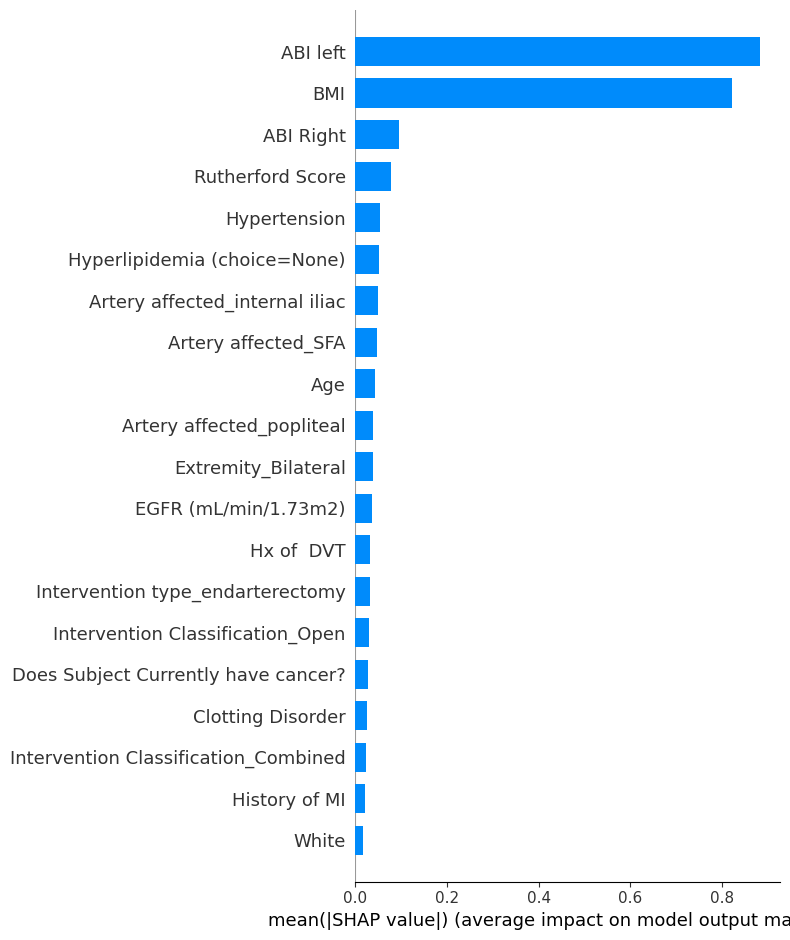

In [74]:
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Get feature importance

In [76]:
# Calculate feature importance using the absolute mean of SHAP values
feature_importance = np.abs(shap_values).mean(axis=0)

# Create a DataFrame to associate feature names with their importance values
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order to find the most important features
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
53,ABI left,0.866331
32,BMI,0.829310
52,ABI Right,0.096785
51,Rutherford Score,0.076116
35,Hypertension,0.052814
...,...,...
62,Statin within 24 Hours_Lovastatin,0.000000
56,Days from operation,0.000000
55,BP_Diastolic,0.000000
54,BP_Systolic,0.000000


## Train model 2
After the user selects non-correlated parameters the model will be retrained dropping the values that were not selected

In [77]:
STOP 
we' can do this after the rest has been put into the UI

SyntaxError: unterminated string literal (detected at line 2) (2728382599.py, line 2)

In [ ]:
# Select only the other features and the ones selected by user
selected_features = {
"Clot treatment drugs":"HKH MA (mm) (3.6591007709503174%)",
"Effects of fibrogen":"ActF MA (mm) (1.9013619422912598%)",
"Heparin effect":"HKH MA (mm) (3.6591007709503174%)",
"Unaltered blood ":"CK MA (mm)_difference_since_last_timepoint (0.0%)",
"Unaltered time to clot ":"CK R (min) (1.8973780870437622%)",
}


In [ ]:
selected_features_list = []

# Process the values in the dictionary
for key, value in selected_features.items():
    # Remove patterns matching (float%)
    selected_features_list.append(re.sub(r'\(\d+\.\d+%\)', '', value).strip())
selected_features_list

In [ ]:
# Extract the features mentioned in the "Feature" column of non_teg_df
non_teg_features = non_teg_df['Feature'].tolist()
selected_features_list =  selected_features_list + non_teg_features
selected_features_list

In [ ]:
# Filter the columns of the original DataFrame based on the selected features
filtered_df = df[selected_features_list]
filtered_df